# **Setting Up** #

**Importing Libraries:** This cell imports essential libraries for data analysis and machine learning:

1. pandas for data manipulation and analysis using DataFrames.
2. numpy for numerical operations and working with arrays.
3. matplotlib.pyplot for creating visualizations like plots and charts.
4. seaborn for creating statistically and aesthetically appealing visualizations.

**Loading Data:** It reads the CSV file log2.csv into a pandas DataFrame named df.

**Previewing Data:** df.head() shows the first 5 rows of the data, allowing you to quickly inspect the structure and content.

In [19]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [20]:
df = pd.read_csv('/kaggle/input/internet-traffic/traffic.csv')

In [21]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Action
0,57222,53,54587,53,177,94,83,2,30,1,1,allow
1,56258,3389,56258,3389,4768,1600,3168,19,17,10,9,allow
2,6881,50321,43265,50321,238,118,120,2,1199,1,1,allow
3,50553,3389,50553,3389,3327,1438,1889,15,17,8,7,allow
4,50002,443,45848,443,25358,6778,18580,31,16,13,18,allow


## Data Exploration

# **Initial Data Exploration** #
**Boxplots:** This cell generates boxplots for each numerical feature (column) in the DataFrame.
1. Boxplots are a useful visualization tool to understand the distribution of data, including median, quartiles, and potential outliers.
2. The code creates a grid of boxplots (2 rows x 6 columns) to accommodate all the features.
3. The plt.tight_layout() and plt.savefig() functions ensure proper spacing and save the figure as "boxplot.png" for later reference.

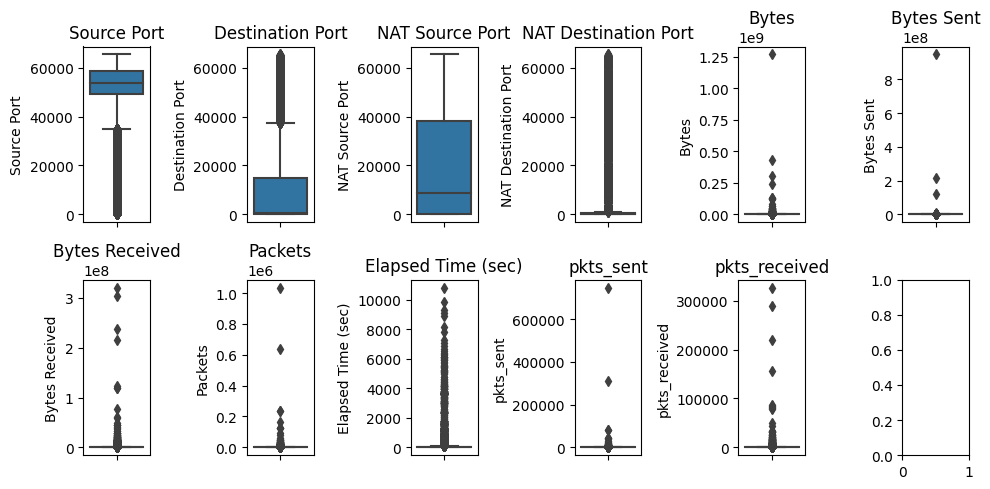

In [22]:
#Boxplots for determining preprocessing
fig, axes = plt.subplots(2, 6, figsize=(10, 5))
axes = axes.ravel()
for i, column in enumerate(df.columns[:-1]):
    sns.boxplot(y=column, data=df, ax=axes[i])
    axes[i].set_title(column)
plt.tight_layout()
plt.savefig('boxplot.png')
plt.show()

In [23]:
#boxplot shows that we need to do alot of data preprocessing

# **Handling Outliers (Incomplete)** # 
**handle_outliers Function:** This function is designed to process outliers in a specific column using either the "winsorize" or "cap" method.
**Winsorizing:** Replaces extreme outliers with the values at specified percentiles (e.g., replacing values below the 1st percentile and above the 99th percentile with the values at those percentiles).
Capping: Sets an upper limit based on a percentile and replaces any values exceeding that limit with the cap value.
# **Applying Outlier Handling:** #
The code defines a list of column names (outlier_columns) where outlier handling should be applied.
However, it encounters a TypeError due to a non-numerical value ("allow") present in one of these columns. This error needs to be fixed before proceeding.

In [24]:
def handle_outliers(df, column, method="winsorize", percentile=99):
    """
    Handles outliers using winsorization or capping.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        column (str): The name of the column to process.
        method (str, optional): "winsorize" or "cap". Defaults to "winsorize".
        percentile (int, optional): Percentile to use for capping/winsorizing. Defaults to 99.
    """
    if method == "winsorize":
        upper_limit = np.percentile(df[column], percentile)
        lower_limit = np.percentile(df[column], 100 - percentile)
        df[column] = np.clip(df[column], lower_limit, upper_limit)
    elif method == "cap":
        upper_limit = np.percentile(df[column], percentile)
        df[column] = np.where(df[column] > upper_limit, upper_limit, df[column])
    else:
        raise ValueError("Invalid method. Choose 'winsorize' or 'cap'.")
    return df


In [25]:
outlier_columns = ["Source Port", "Destination Port", "Bytes", "Bytes Sent", 
                   "Bytes Received", "Elapsed Time (sec)", "pkts_sent", "pkts_received"]
for col in outlier_columns:
    df = handle_outliers(df, col)

# **Removing Low Variance Features (Incomplete)** #
**remove_low_variance_columns Function:** This function aims to eliminate features with very low variance, which might not be informative for the machine learning model.
It calculates the variance of each column and drops those falling below a specified threshold (default is 0.01).
**Applying Feature Removal:** The code attempts to apply the function but might not execute successfully due to the error in the previous cell.

In [26]:
def remove_low_variance_columns(df, threshold=0.01):
    """
    Removes columns with variance below a threshold.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        threshold (float, optional): Variance threshold for removal. Defaults to 0.01.
    """
    # convert string columns to float
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = pd.to_numeric(df[col], errors="coerce")
    variances = df.var()
    low_variance_cols = variances[variances < threshold].index.tolist()
    df.drop(low_variance_cols, axis=1, inplace=True)
    return df

df2 = remove_low_variance_columns(df.iloc[:,:-1])
df2['Action'] = df['Action']
df = df2
del df2

In [27]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Action
0,57222,53,54587,53,177.0,94.0,83.0,2,30,1,1.0,allow
1,56258,3389,56258,3389,4768.0,1600.0,3168.0,19,17,10,9.0,allow
2,6881,50321,43265,50321,238.0,118.0,120.0,2,1199,1,1.0,allow
3,50553,3389,50553,3389,3327.0,1438.0,1889.0,15,17,8,7.0,allow
4,50002,443,45848,443,25358.0,6778.0,18580.0,31,16,13,18.0,allow


# **Log Transformation** #
**apply_log_transform Function:** This function applies a log transformation to the specified columns. A log transformation can be helpful for:
1. Normalizing skewed distributions, making the data more suitable for certain machine learning algorithms.
2. Reducing the impact of outliers.
3. Improving the interpretability of features in some cases.
**Applying Transformation:** The code defines a list of columns (log_transform_columns) to be transformed and then applies the apply_log_transform function.
1. The np.log1p function is used, which applies the natural logarithm after adding 1 to the values. This handles cases where the original values are 0.

In [ ]:
def apply_log_transform(df, columns):
    """
    Applies log transformation to specified columns.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        columns (list): List of columns to transform.
    """
    for col in columns:
        df[col] = np.log1p(df[col])
    return df

log_transform_columns = ["Bytes", "Bytes Sent", "Bytes Received", 
                        "Elapsed Time (sec)", "pkts_sent", "pkts_received"]
df = apply_log_transform(df, log_transform_columns)

# **Visualizing Transformed Data** #
**Boxplots After Transformation:** This cell creates boxplots again for the transformed data. Comparing these plots with the initial boxplots (Cell 2) helps visualize how the log transformation has affected the distributions of the features.

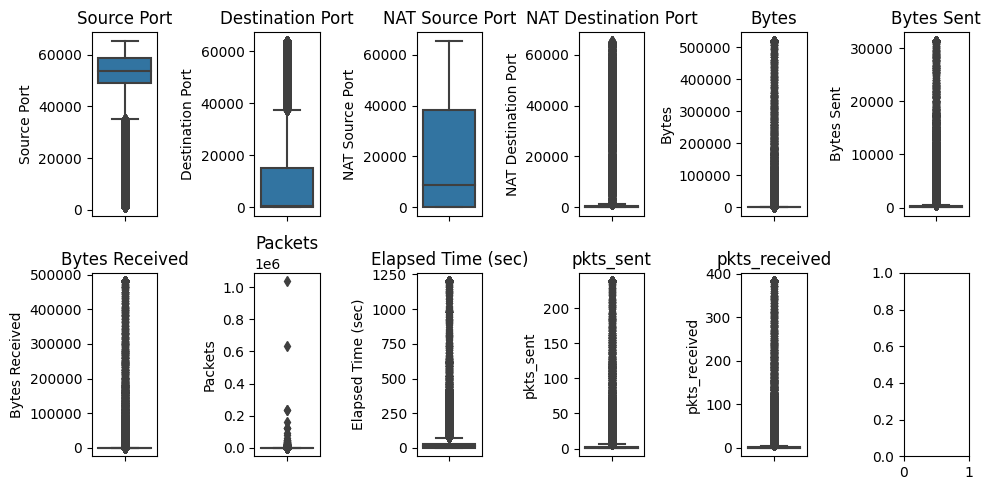

In [29]:
# make boxplots again
fig, axes = plt.subplots(2, 6, figsize=(10, 5))
axes = axes.ravel()
for i, column in enumerate(df.columns[:-1]):
    sns.boxplot(y=column, data=df, ax=axes[i])
    axes[i].set_title(column)
plt.tight_layout()
plt.savefig('boxplot_after.png')
plt.show()

In [30]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# **Examining Removed Outliers (Incomplete)** #
**handle_outliers_examined Function:** This function is similar to the handle_outliers function but also stores the removed outlier values for further analysis if needed.

**Incomplete Code:** The cell appears incomplete as the removed_outliers_dict is not defined and there's a placeholder comment (##### Code Text).

In [31]:
def handle_outliers_examined(df, column, method="winsorize", percentile=99):
    """
    Handles outliers with examination of removed values.
    """
    if method == "winsorize":
        upper_limit = np.percentile(df[column], percentile)
        lower_limit = np.percentile(df[column], 100 - percentile)
        removed_outliers = df[(df[column] < lower_limit) | (df[column] > upper_limit)][column]
        df[column] = np.clip(df[column], lower_limit, upper_limit)
    elif method == "cap":
        upper_limit = np.percentile(df[column], percentile)
        removed_outliers = df[df[column] > upper_limit][column]
        df[column] = np.where(df[column] > upper_limit, upper_limit, df[column])
    else:
        raise ValueError("Invalid method. Choose 'winsorize' or 'cap'.")
    return removed_outliers
outlier_columns = ["Source Port", "Destination Port", "Bytes", "Bytes Sent", 
                   "Bytes Received", "Elapsed Time (sec)", "pkts_sent", "pkts_received"]
removed_outliers_dict = {}
for col in outlier_columns:
    removed_outliers_dict[col] = handle_outliers_examined(df, col)

# **Preparing for Modeling (Assuming Errors Fixed)** #

**Feature/Target Separation:**

* **X = df.drop("Action", axis=1):** Removes the "Action" column (presumably the target variable) from the DataFrame and stores the remaining features in X.
* **y = df["Action"]:** Extracts the "Action" column as the target variable y.

# **One-Hot Encoding:** #

* **y = pd.get_dummies(y):** Applies one-hot encoding to the categorical target variable y. This converts categorical values into multiple binary columns, suitable for many machine learning algorithms.
* **Importing sklearn Modules:** Imports necessary modules from sklearn for feature selection, scaling, and train-test split.

# **Feature Selection with Random Forest:** #

* Trains a Random Forest Classifier on the data (X, y).
* Uses SelectFromModel to select features based on their importance scores from the trained model.
* Features with importance scores below the threshold (0.05) are dropped.
* Data Scaling: Applies StandardScaler to standardize the features (mean=0, variance=1).

* **Train-Test Split:** Splits the data into training and testing sets with a test size of 20% and a random state of 42.

In [32]:
X = df.drop("Action", axis=1, inplace = False)  # Replace "Target Variable" with your target column name
y = df["Action"]
# convert target variable to categorical
y = pd.get_dummies(y)

In [53]:
y

,allow,deny,drop,reset-both
0,True,False,False,False
1,True,False,False,False
2,True,False,False,False
3,True,False,False,False
4,True,False,False,False
...,...,...,...,...
65527,True,False,False,False
65528,True,False,False,False
65529,False,False,True,False
65530,False,False,True,False


In [34]:
model = RandomForestClassifier()
model.fit(X, y)

RandomForestClassifier()

**Selecting important features playing important role**

In [35]:
importances = model.feature_importances_

In [36]:
selector = SelectFromModel(model, prefit=True, threshold=0.05)  # Adjust threshold as needed
X_reduced = selector.transform(X)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [54]:
# \Scaling the features on a common scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [55]:
train_x, test_x, train_y, test_y = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
# train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# Method 1
## RandomForestClassifier 

In [58]:
#do training using random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = RandomForestClassifier(random_state=42)

In [59]:
#start training for the model
model.fit(train_x, train_y)


RandomForestClassifier(random_state=42)

In [60]:
# evaluate the model
preds = model.predict(test_x)
accuracy = accuracy_score(test_y, preds)
print(f"Accuracy: {accuracy}")
print(classification_report(test_y, preds))


Accuracy: 0.9984740978103304
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7545
           1       1.00      1.00      1.00      2994
           2       1.00      1.00      1.00      2562
           3       1.00      0.67      0.80         6

   micro avg       1.00      1.00      1.00     13107
   macro avg       1.00      0.92      0.95     13107
weighted avg       1.00      1.00      1.00     13107
 samples avg       1.00      1.00      1.00     13107



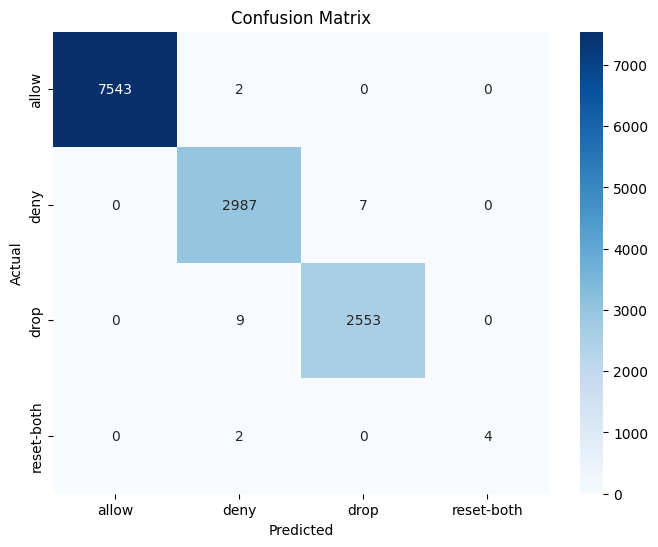

In [61]:
# confusion matrix
cm = confusion_matrix(test_y.values.argmax(axis=1), preds.argmax(axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=y.columns, yticklabels=y.columns)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('confusion_matrix.png')

# Method 2
## Logistic Regression

In [63]:
# now training on logistic regression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42, max_iter=1000)

In [64]:
train_logistic_y = train_y.values.argmax(axis=1)
test_logistic_y = test_y.values.argmax(axis=1)

In [65]:
model.fit(train_x, train_logistic_y)

LogisticRegression(max_iter=1000, random_state=42)

In [66]:
# evaluate the model
preds = model.predict(test_x)
accuracy = accuracy_score(test_logistic_y, preds)
print(f"Accuracy: {accuracy}")
print(classification_report(test_logistic_y, preds))


Accuracy: 0.9887083237964447
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7545
           1       0.99      0.96      0.98      2994
           2       0.95      1.00      0.98      2562
           3       0.00      0.00      0.00         6

    accuracy                           0.99     13107
   macro avg       0.74      0.74      0.74     13107
weighted avg       0.99      0.99      0.99     13107



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


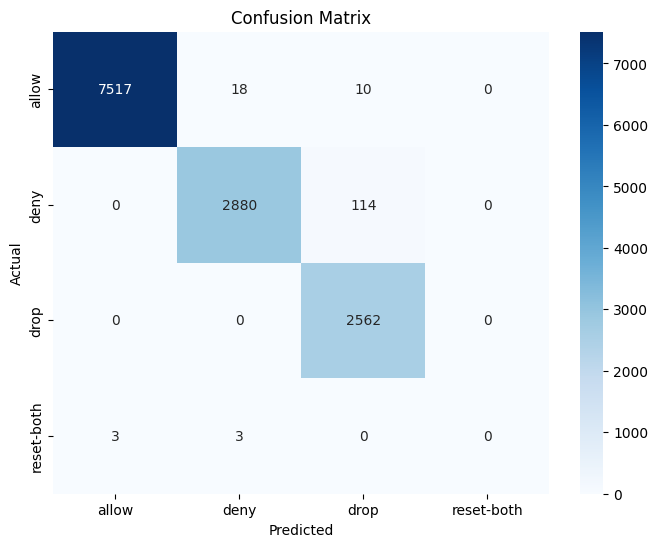

In [67]:
# confusion matrix
cm = confusion_matrix(test_logistic_y, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=y.columns, yticklabels=y.columns)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('confusion_matrix_logistic.png')

# Method 3
## K Neighbours Classifier

In [69]:
# now training on KNN
from sklearn.neighbors import KNeighborsClassifier

In [70]:
model = KNeighborsClassifier()

model.fit(train_x, train_logistic_y)

KNeighborsClassifier()

In [71]:
# evaluate the model
preds = model.predict(test_x)
accuracy = accuracy_score(test_logistic_y, preds)
print(f"Accuracy: {accuracy}")
print(classification_report(test_logistic_y, preds))


Accuracy: 0.9975585564965286
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7545
           1       1.00      0.99      1.00      2994
           2       1.00      1.00      1.00      2562
           3       0.00      0.00      0.00         6

    accuracy                           1.00     13107
   macro avg       0.75      0.75      0.75     13107
weighted avg       1.00      1.00      1.00     13107



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


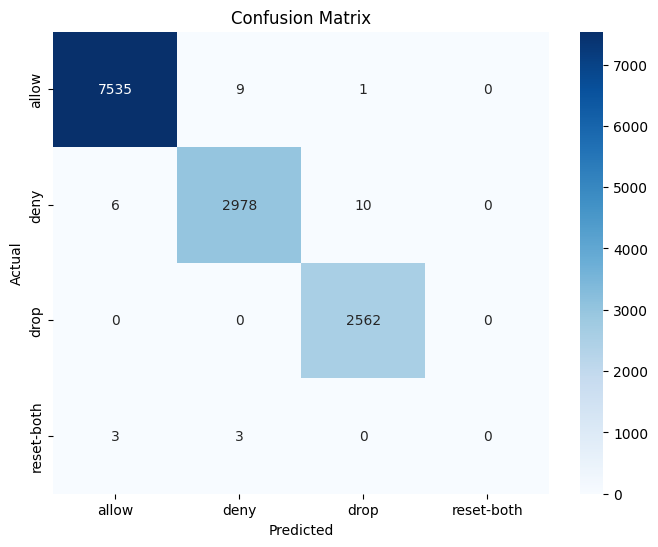

In [72]:
# confusion matrix
cm = confusion_matrix(test_logistic_y, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=y.columns, yticklabels=y.columns)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('confusion_matrix_knn.png')
